In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

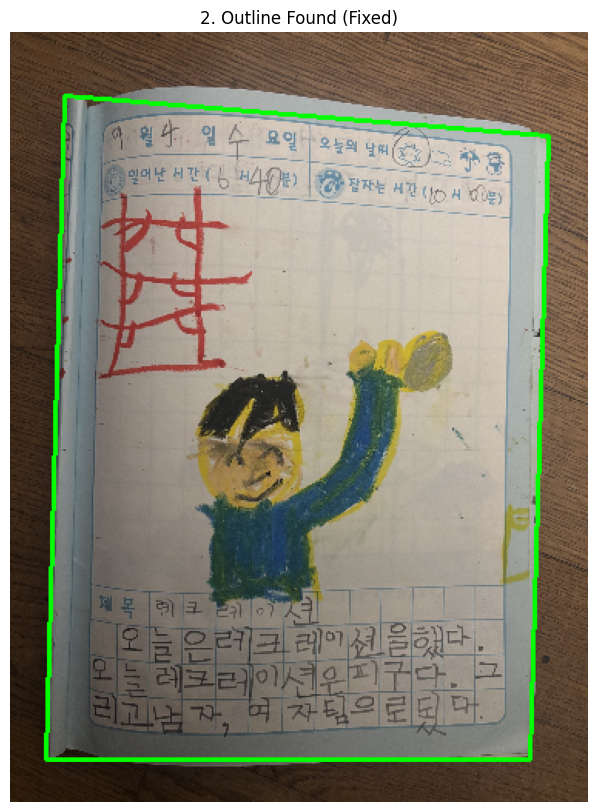

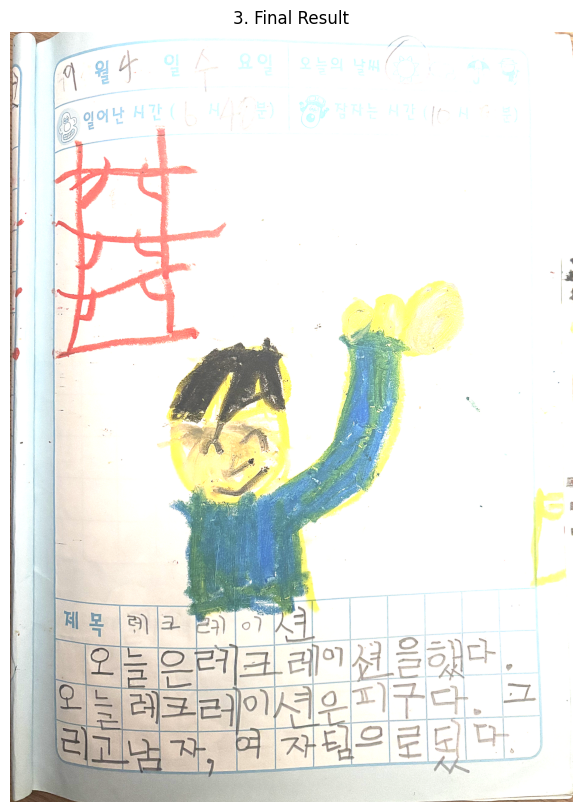

변환 성공! 저장 완료.


In [49]:
def imshow(title, image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.axis('off')
    plt.show()

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(image, M, (maxWidth, maxHeight))

def scan_effect_color(img):
    img_blur = cv2.GaussianBlur(img, (3,3), 0)
    enhanced = cv2.convertScaleAbs(img_blur, alpha=1.8, beta=30)
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    return cv2.filter2D(enhanced, -1, kernel)

# === 메인 실행 코드 ===
file_path = 'img1.jpg' # 파일명 확인!
image = cv2.imread(file_path)

if image is None:
    print("이미지를 찾을 수 없습니다.")
else:
    orig = image.copy()
    ratio = image.shape[0] / 500.0
    h = 500
    w = int(image.shape[1] / ratio)
    image_resized = cv2.resize(image, (w, h))

    gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # 1. Edge Detection
    edged = cv2.Canny(gray, 50, 150)
    
    # [수정 1] 커널 크기를 다시 (5,5)로 키워서 끊어진 선을 확실히 이어줍니다.
    kernel = np.ones((5,5), np.uint8)
    edged = cv2.dilate(edged, kernel, iterations=1)
    
    # 2. Contours 찾기
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5] # 가장 큰 5개만 봄

    screenCnt = None
    
    # [수정 2] 둥근 모서리 해결을 위한 루프
    for c in cnts:
        peri = cv2.arcLength(c, True)
        
        # approxPolyDP의 두 번째 인자(0.02)를 조절하면 단순화 강도가 달라집니다.
        # 0.02로 못 찾으면 -> 0.05(더 뭉뚱그려서) -> 0.1(아주 단순하게) 순서로 시도합니다.
        for epsilon_val in [0.02, 0.05, 0.08]: 
            approx = cv2.approxPolyDP(c, epsilon_val * peri, True)
            
            # 점이 4개면 성공!
            if len(approx) == 4:
                screenCnt = approx
                break
        
        if screenCnt is not None:
            break

    # [수정 3] 만약 여전히 못 찾았다면? 그냥 '가장 큰 덩어리'의 외곽 사각형을 가져옵니다.
    if screenCnt is None and len(cnts) > 0:
        print("정확한 사각형을 못 찾아서, 가장 큰 영역을 강제로 선택합니다.")
        rect = cv2.minAreaRect(cnts[0])
        box = cv2.boxPoints(rect)
        screenCnt = np.int0(box)

    if screenCnt is None:
        print("문서를 찾을 수 없습니다.")
    else:
        cv2.drawContours(image_resized, [screenCnt], -1, (0, 255, 0), 2)
        imshow("2. Outline Found (Fixed)", image_resized)

        # 좌표 변환 시 float32 타입으로 변환 필요
        warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
        scanned_result = scan_effect_color(warped)

        imshow("3. Final Result", scanned_result)
        cv2.imwrite('scan_result_final.jpg', scanned_result)
        print("변환 성공! 저장 완료.")